In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import sys

In [27]:
# LOAD DATA FROM ALL FILES IN THE ROOT FOLDER. IF ONE FILE CONTAINS MULTIPLE SUBJECTS, THEN ALL OF THEM WILL BE LOADED.
human_data_path = "../data/human_data.txt"
dfs = []
with open(human_data_path, 'r') as f:
	lines = f.readlines()
	for l in lines:
		# write into temp file if valid
		if l.startswith('['):
			with open("temp.txt", "w") as temp_file:
				temp_file.write(l)
		with open("temp.txt", "r") as temp_file:
			dfs.append(pd.read_json(temp_file, orient='records'))
	os.remove("temp.txt")

dfs[0].head()

,url,meta,sender,sender_type,sender_id,do-you-agree-to-participate-and-are-you-above-18-years-old.-undefined,what-describes-you-best-(male-female-others-prefer-not-to-say),please-enter-your-age-in-years.-(digits-only),do-you-need-glassescontact-lenses-to-read,are-you-wearing-them-(put-,...,time_switch,response,response_action,parameter0,looper,category,mode,filename,correctResponse,correct
0,{'srid': '3032'},"{'labjs_version': '20.2.4', 'labjs_build': {'f...",Agreement,html.Page,0.0,1.0,Female,30.0,no,NA,...,73360.690,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,Training Instructions,html.Page,1.0,NaN,NaN,NaN,NaN,NaN,...,77676.184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,ScreenTraining,canvas.Screen,2.0,NaN,NaN,NaN,NaN,NaN,...,80758.657,click,click @fixation,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,Stimulus & Response,html.Screen,300.0,NaN,NaN,NaN,NaN,NaN,...,88973.207,oven,click button#oven,1.0,0.0,clock,noise0.16freq4,18_cbm_noise0.16_freq4_gray_g_clock.JPEG,clock,0.0
4,NaN,NaN,inter-stimulus,canvas.Screen,301.0,NaN,NaN,NaN,NaN,NaN,...,90072.894,click,click @fixation,1.0,0.0,NaN,NaN,NaN,NaN,NaN


In [28]:
# iterate through rows of df and store stim response record for each in appropriate block
def get_start_index(df, blockname):
	return df.loc[df['sender'] == "Screen" + blockname].index[0]

all_start_indices = []
for df in dfs:
	# get all start indices
	train_idx = get_start_index(df, "Training")
	test0_idx = get_start_index(df, "0")
	test1_idx = get_start_index(df, "1")
	test2_idx = get_start_index(df, "2")
	test3_idx = get_start_index(df, "3")
	test4_idx = get_start_index(df, "4")
	start_indices = [train_idx, test0_idx, test1_idx, test2_idx, test3_idx, test4_idx]

	all_start_indices.append(start_indices)
	print(df['url'][0], start_indices)

{'srid': '3032'} [2, 155, 788, 1421, 2054, 2687]
{'srid': '3026'} [2, 155, 788, 1421, 2054, 2687]
{'srid': '3025'} [2, 155, 788, 1421, 2054, 2687]
{'srid': '3024'} [2, 155, 788, 1421, 2054, 2687]
{'srid': '3038'} [2, 155, 788, 1421, 2054, 2687]
{'srid': '3037'} [2, 155, 788, 1421, 2054, 2687]
{'srid': '3035'} [2, 155, 788, 1421, 2054, 2687]
{'srid': '3034'} [2, 155, 788, 1421, 2054, 2687]
{'srid': '3033'} [2, 155, 788, 1421, 2054, 2687]
{'srid': '3046'} [2, 155, 788, 1421, 2054, 2687]
{'srid': '3045'} [2, 155, 788, 1421, 2054, 2687]
{'srid': '3044'} [2, 155, 788, 1421, 2054, 2687]
{'srid': '3042'} [2, 155, 788, 1421, 2054, 2687]
{'srid': '3041'} [2, 155, 788, 1421, 2054, 2687]


In [29]:
# Store stimulus response data (after skipping first 10 rows) for each timed block
# blocks = ["cattut", "motortime", "0", "400", "600", "800", "1000"]
blocks = ["training", "0", "1", "2", "3", "4"]
blocked_datas = []

def get_sr_block_data(df, start_idx, n_samples, n_skip=0):
	block_df = df.iloc[start_idx:start_idx + n_samples + 1]
	return block_df[block_df["sender"] == "Stimulus & Response"][n_skip:]

LEAVE_OUT_DFS = []
for i, df in enumerate(dfs):
	if df['url'][0]['srid'] in LEAVE_OUT_DFS:
		continue

	blocked_data = {}

	for j, block in enumerate(blocks):
		if block == "training":
			blocked_data[block] = get_sr_block_data(df, all_start_indices[i][j], 50*3)

		else:
			blocked_data[block] = get_sr_block_data(df, all_start_indices[i][j], 210*3)

	blocked_datas.append(blocked_data)

In [30]:
# Replace all NaN values with random category
categories = ["airplane", 'bear', 'bicycle', 'bird', 'boat', 'bottle', 'car', 'cat', 'chair', 'clock', 'dog', 
	       'elephant', 'keyboard', 'knife', 'oven', 'truck']
for i, blocked_data in enumerate(blocked_datas):
	for j, block in enumerate(blocks[1:]):
		response_idx = blocked_data[block].columns.get_loc("response")
		b = blocked_data[block].values
		n = b[:, response_idx].astype(str) == 'nan'
		b[:, response_idx][n] = np.random.choice(categories, size=np.sum(n))
		blocked_datas[i][block] = pd.DataFrame(b, columns=blocked_data[block].columns)

In [31]:
# Compute training accuracy
cat_accs = []
for blocked_data, df in zip(blocked_datas, dfs):
	accuracy_training = blocked_data['training']['correct'].sum() / len(blocked_data['training']['correct'])
	cat_accs.append(accuracy_training * 100)
	print("{}: Accuracy on categorization training: {} %".format(df['url'][0], accuracy_training * 100))

{'srid': '3032'}: Accuracy on categorization training: 60.0 %
{'srid': '3026'}: Accuracy on categorization training: 82.0 %
{'srid': '3025'}: Accuracy on categorization training: 84.0 %
{'srid': '3024'}: Accuracy on categorization training: 84.0 %
{'srid': '3038'}: Accuracy on categorization training: 88.0 %
{'srid': '3037'}: Accuracy on categorization training: 88.0 %
{'srid': '3035'}: Accuracy on categorization training: 84.0 %
{'srid': '3034'}: Accuracy on categorization training: 80.0 %
{'srid': '3033'}: Accuracy on categorization training: 88.0 %
{'srid': '3046'}: Accuracy on categorization training: 90.0 %
{'srid': '3045'}: Accuracy on categorization training: 86.0 %
{'srid': '3044'}: Accuracy on categorization training: 84.0 %
{'srid': '3042'}: Accuracy on categorization training: 82.0 %
{'srid': '3041'}: Accuracy on categorization training: 88.0 %


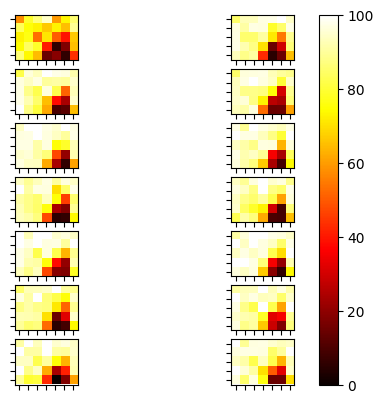

In [45]:
# INDIVIDUAL HEATMAPS
# Plot accuracy for each noise-sf combination
final_mat = np.zeros((5, 7))
nrows, ncols = 7,2
fig, ax = plt.subplots(nrows,ncols, sharex=True, sharey=True)
for i, blocked_data in enumerate(blocked_datas):
	mode_accuracies = {}
	for block in blocks[1:]:
		block = blocked_data[block]

		for idx, trial in block.iterrows():
			if trial['mode'] not in mode_accuracies:
				mode_accuracies[trial['mode']] = [trial['correct']]
			else:
				mode_accuracies[trial['mode']].append(trial['correct'])

	# plot matrix for each subject
	noise_list = list(map(str, [0, 0.02, 0.04, 0.08, 0.16]))
	freq_list = list(map(str, range(7)))
	accuracy_matrix = np.zeros((len(noise_list), len(freq_list)))

	for mode in mode_accuracies:
		mode_split = re.findall(r"[-+]?(?:\d*\.\d+|\d+)", mode)
		noise, freq = mode_split[0], mode_split[1]
		accuracy_matrix[noise_list.index(noise), freq_list.index(freq)] = np.mean(mode_accuracies[mode]) * 100

	# add to final mat, which will eventually be normalized to get average accuracy
	final_mat += accuracy_matrix

	# show accuracy matrix as color map
	axi = ax[i//ncols][i%ncols]
	im = axi.imshow(accuracy_matrix, cmap='hot', interpolation='nearest', vmin=0, vmax=100)
plt.colorbar(im, ax=ax)

final_mat /= len(blocked_datas)
axi.set_xticks(np.arange(len(freq_list)))
axi.set_yticks(np.arange(len(noise_list)))
axi.set_xticklabels([])
axi.set_yticklabels([])

plt.show()

[[100.          89.28571429  96.66666667  97.14285714  95.23809524
   93.33333333  94.28571429]
 [ 96.66666667  96.875       96.96969697  96.66666667  84.84848485
   90.         100.        ]
 [ 93.93939394  91.17647059  82.35294118  93.5483871   82.14285714
   63.63636364  92.59259259]
 [100.          96.          90.90909091  70.27027027  50.
   32.35294118  94.59459459]
 [ 96.55172414  85.29411765  96.77419355  76.19047619  14.28571429
   14.70588235  69.56521739]]


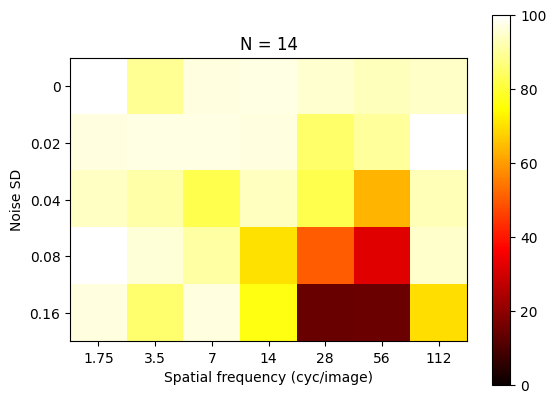

In [47]:
# AVERAGE HEATMAP
# Plot accuracy for each noise-sf combination
final_mat = np.zeros((5, 7))
for i, blocked_data in enumerate(blocked_datas):
	mode_accuracies = {}
	for block in blocks[1:]:
		block = blocked_data[block]

		for idx, trial in block.iterrows():
			if trial['mode'] not in mode_accuracies:
				mode_accuracies[trial['mode']] = [trial['correct']]
			else:
				mode_accuracies[trial['mode']].append(trial['correct'])

	# plot matrix for each subject
	noise_list = list(map(str, [0, 0.02, 0.04, 0.08, 0.16]))
	freq_list = list(map(str, range(7)))
	accuracy_matrix = np.zeros((len(noise_list), len(freq_list)))

	for mode in mode_accuracies:
		mode_split = re.findall(r"[-+]?(?:\d*\.\d+|\d+)", mode)
		noise, freq = mode_split[0], mode_split[1]
		accuracy_matrix[noise_list.index(noise), freq_list.index(freq)] = np.mean(mode_accuracies[mode]) * 100

	# add to final mat, which will eventually be normalized to get average accuracy
	final_mat += accuracy_matrix

	# show accuracy matrix as color map
	# plt.imshow(accuracy_matrix, cmap='hot', interpolation='nearest')
	# plt.xlabel('Spatial frequency index')
	# plt.ylabel('Noise SD index')
	# plt.colorbar()
	# plt.show()

final_mat /= len(blocked_datas)

cpi_list = list(map(str, [1.75, 3.5, 7, 14, 28, 56, 112]))
fig, ax = plt.subplots()

ax.set_xticks(np.arange(len(cpi_list)))
ax.set_xticklabels(cpi_list)

ax.set_yticks(np.arange(len(noise_list)))
ax.set_yticklabels(noise_list)

vmin = 0
vmax = 100
im = ax.imshow(accuracy_matrix, cmap='hot', interpolation='nearest', vmin=vmin, vmax=vmax)
print(accuracy_matrix)
fig.colorbar(im, ax=ax)

plt.xlabel('Spatial frequency (cyc/image)')
plt.ylabel('Noise SD')
plt.title(f"N = {len(blocked_datas)}")

# save = './Figures/solomon_human_heatmap.pdf'
# os.makedirs(os.path.dirname(save), exist_ok=True)
plt.show()

# fig.savefig(save)

In [48]:
# find 60% accuracy thresholds and fit gaussian
def find_thresholds(accuracy_matrix, threshold_acc=60):
	# compute threshold indices
	thresholds = []
	for i in range(accuracy_matrix.shape[1]):
		for j in range(accuracy_matrix.shape[0]):
			jr = len(accuracy_matrix) - 1 - j
			if accuracy_matrix[jr, i] > threshold_acc:
				break
		thresholds.append(j)

	thresholds = np.array(thresholds)

	return thresholds

thresholds = find_thresholds(accuracy_matrix, 60)
thresholds

array([0, 0, 0, 0, 2, 2, 0])

/var/folders/lk/bpljp3d534xd8_2v7v7m9lgc0000gn/T/ipykernel_4971/1858230072.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xtl)


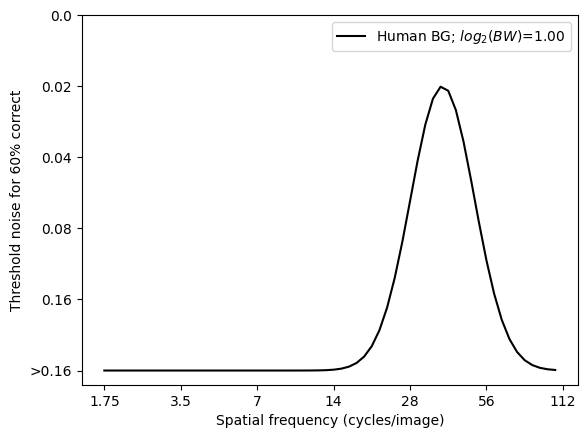

In [49]:
from scipy.optimize import curve_fit

def fit_gaussian(thresholds):
	def gauss(x, *p):
		A, mu, sigma = p
		return A*np.exp(-(x-mu)**2/(2.*sigma**2))

	p0 = [1., 0., 1.]
	coeff, var_matrix = curve_fit(gauss, np.arange(len(thresholds)), thresholds, p0=p0, bounds=((-np.inf,-np.inf,-np.inf),(4, np.inf, np.inf)))
	if 2.355 * coeff[2] < 9:
		stderrs = np.sqrt(np.diag(var_matrix))

	hist_fit = gauss(np.linspace(0, len(thresholds)-1, 60), *coeff)
	
	bw = 2.355 * coeff[2] # For a gaussian, FWHM BW is sigma * 2 * sqrt(ln 2)
	mean = coeff[1]
	height = coeff[0]

	return hist_fit, bw, mean, height

gauss_fit, bw, mean, height = fit_gaussian(thresholds)
fig, ax = plt.subplots()
x = np.arange(0, 6, 6/60)
ax.plot(x, gauss_fit, color='black', label="{}; $log_2(BW)$={:.2f}".format("Human", bw))
thresvar_list = list(map(str, [0.0, 0.02, 0.04, 0.08, 0.16, ">0.16"]))
ax.set_yticks(np.arange(len(thresvar_list)))

xtl = ax.get_xticklabels()
xtl[1:-1] = cpi_list
ax.set_xticklabels(xtl)
ytl = ax.get_yticklabels()
ytl = reversed(thresvar_list)
ax.set_yticklabels(ytl)
ax.set_xlabel("Spatial frequency (cycles/image)")
ax.set_ylabel(f"Threshold noise for 60% correct")
plt.legend()
plt.show()